In [1]:
import tensorflow as tf

import os, urllib, shutil, pathlib

Load Dataset on Kaggle Dataset

In [2]:
origin = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/"

kaggle = "kagglecatsanddogs_5340.zip"

origin += kaggle

In [ ]:
urllib.request.urlretrieve(origin, kaggle)

In [4]:
shutil.unpack_archive(kaggle, '/content', 'zip')

In [5]:
rooter = "/content/PetImages"

os.listdir(rooter)

['Dog', 'Cat']

Delete Corrupt Images

In [6]:
def imroot(root):

  i = 0
  for item in os.listdir(root):
    roti = os.path.join(root, item)
    try:
      inputi = open(roti, "rb")
      images = tf.compat.as_bytes("JFIF") in inputi.peek(10)
    finally:
      inputi.close()

    if not images:
      i += 1
      os.remove(roti)

  return i

cat_lost = imroot(os.path.join(rooter, "Cat"))

dog_lost = imroot(os.path.join(rooter, "Dog"))

cat_lost, dog_lost

(759, 831)

In [7]:
cats = len(os.listdir(os.path.join(rooter, "Cat")))

dogs = len(os.listdir(os.path.join(rooter, "Dog")))

total_images = cats + dogs

total_images

23412

Our Total Images is 23.412 Images After Data Cleaning

In [ ]:
# Load Images Data to TensorFlow Dataset

from tensorflow.keras.utils import image_dataset_from_directory

subset = "both"; label = "binary"

image = (160, 160); split = 0.3; random = 128

unseet = 10

orifile = image_dataset_from_directory(
  rooter,
  seed = unseet,
  subset = subset,
  image_size = image,
  label_mode = label,
  batch_size = random,
  validation_split = split
)

train_complete, test_complete = orifile

# 16387 + 7023

In [ ]:
labeler = train_complete.class_names

labeler

['Cat', 'Dog']

In [10]:
total_train_images = 0

train = train_complete.take(15)

for i_sample, l_sample in iter(train):

  total_train_images += i_sample.shape[0]

total_train_images

1920

In [11]:
test_complete = test_complete.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

total_test_images = 0

test = test_complete.take(8)

for i_sample, l_sample in iter(test):

  total_test_images += i_sample.shape[0]

total_test_images

1024

#### `Model Spirior`

Create Model to Classify Cat or Dog

In [ ]:
# Solution to Image Augmentation

from tensorflow.keras import Model, layers

class SolAug(Model):
  def __init__(self):
    super(SolAug, self).__init__()
    self.rescale = layers.Rescaling(1.0 / 255.0)
    self.rotation_range = layers.RandomRotation(0.2)
    self.random_zoom = layers.RandomZoom(0.2)
    self.random_flip = layers.RandomFlip()

  def call(self, inputs):
    x = self.rescale(inputs)
    x = self.rotation_range(x)
    x = self.random_zoom(x)
    y = self.random_flip(x)
    return y

Solitation = SolAug()

# Perform Caching on Train, Test Dataset to Fasten Model Training

autotune = tf.data.AUTOTUNE

train = train.map(lambda i, l : (Solitation(i), l)).cache().prefetch(buffer_size = autotune)

test = test.map(lambda i, l : (Solitation(i), l)).cache().prefetch(buffer_size = autotune)

#### `First Model`

In [ ]:
import warnings

warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential

from tensorflow.keras import Model, layers

model = Sequential([
  layers.Conv2D(16, (3,3), activation='relu', input_shape=(160, 160, 3)),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dropout(0.4),
  layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.Dense(1, activation=tf.nn.sigmoid)
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

simp_model = model.fit(train, epochs=18, validation_data=test)

In [14]:
model.evaluate(train, verbose=False)

[0.5473127961158752, 0.7942708134651184]

In [15]:
model.evaluate(test, verbose=False)

[0.7189428806304932, 0.6396484375]

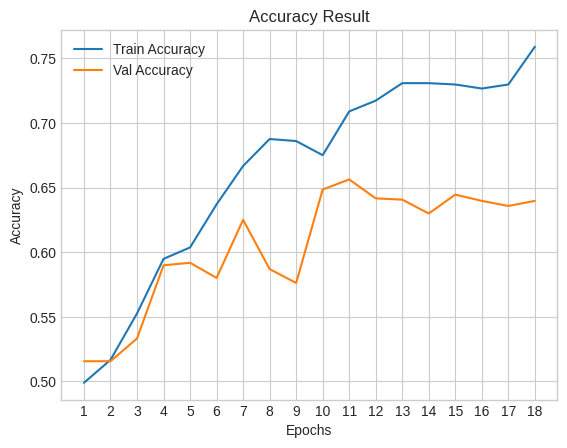

In [16]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

class Helplot:
  def __init__(self, history):
    self.history = history
    self.accuracy = history.history['accuracy']
    self.val_accuracy = history.history['val_accuracy']
    self.loop = [*range(1, len(self.accuracy) + 1)]
    self.loss = history.history['loss']
    self.val_loss = history.history['val_loss']

  @property
  def Relplot(self):
    plt.plot(self.loop, self.accuracy, label='Train Accuracy')
    plt.plot(self.loop, self.val_accuracy, label='Val Accuracy')
    plt.title("Accuracy Result")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(self.loop)
    plt.legend()

  @property
  def Falplot(self):
    plt.plot(self.loop, self.loss, label='Train Loss')
    plt.plot(self.loop, self.val_loss, label='Val Loss')
    plt.title("Loss Result")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(self.loop)
    plt.legend()

simp_plot = Helplot(simp_model)

simp_plot.Relplot

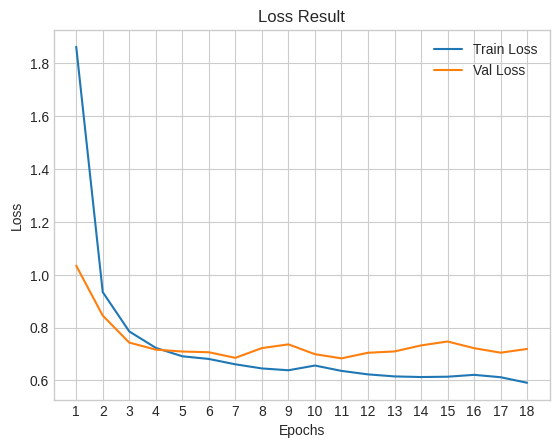

In [17]:
simp_plot.Falplot

#### `Main Model`

In [ ]:
from tensorflow.keras.applications import MobileNet

base_model = MobileNet(input_shape=(160, 160, 3), weights="imagenet", include_top=False)

base_model.trainable = False

In [19]:
inputs = layers.Input(shape=(160, 160, 3))

x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation=tf.nn.sigmoid)(x)

supa_model = Model(inputs, outputs)

In [20]:
supa_model.inputs

[<KerasTensor shape=(None, 160, 160, 3), dtype=float32, sparse=None, name=keras_tensor_98>]

In [21]:
supa_model.outputs

[<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_102>]

In [22]:
supa_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
supa_hist = supa_model.fit(train, epochs=10, validation_data=test)

#### `Model Test`

In [24]:
supa_model.evaluate(train, verbose=False)

[0.1739131361246109, 0.9348958134651184]

In [25]:
supa_model.evaluate(test, verbose=False)

[0.2479652315378189, 0.8916015625]

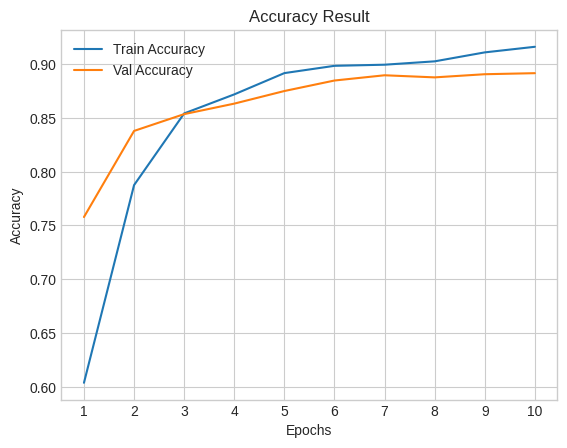

In [26]:
supa_plot = Helplot(supa_hist)

supa_plot.Relplot

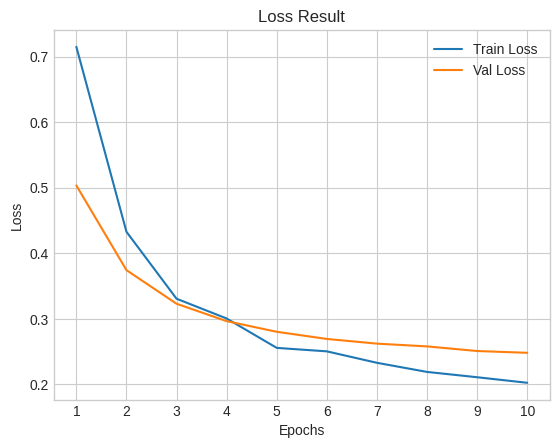

In [27]:
supa_plot.Falplot

#### `TensorFlow Lite`

Deploy Our Model on TensorFlow Lite

In [ ]:
ModelFolder = "/content/Modelite"

supa_model.export(ModelFolder)

In [29]:
tflite = tf.lite.TFLiteConverter

tflite_model = tflite.from_saved_model(ModelFolder)

tflite_model.optimizations = [tf.lite.Optimize.DEFAULT]

In [30]:
tflite_model.inference_input_type, tflite_model.inference_output_type

(tf.float32, tf.float32)

In [31]:
tflite_model = tflite_model.convert()

pathfile = "HartModel01.tflite"

tflite_model_file = pathlib.Path(pathfile)

tflite_model_file.write_bytes(tflite_model)

3385504

In [32]:
os.path.getsize(pathfile) / float(2**20)

3.228668212890625

In [33]:
interpreter = tf.lite.Interpreter(model_path=pathfile)

interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_98'], 'outputs': ['output_0']}}

In [34]:
lite_interpreter = interpreter.get_signature_runner('serving_default')

lite_interpreter

In [35]:
test_images, test_labels = next(iter(test))

tensorlite_test = lite_interpreter(keras_tensor_98=test_images)['output_0']

tensorlite_test.shape

(128, 1)

In [36]:
tensorlite_test[:1]

array([[0.7010224]], dtype=float32)

#### `TensorFlow Serving`

Deploy Our Model on TensorFlow Serving

In [ ]:
!apt update

!apt-get install tensorflow-model-server

In [38]:
class Outlabel(tf.keras.layers.Layer):
  def __init__(self):
    super(Outlabel, self).__init__()
    self.label = labeler

  def call(self, inputs):
    tf.config.run_functions_eagerly(True)
    logits = tf.cast(tf.round(inputs), tf.int32)
    logits = tf.gather(self.label, logits)
    return logits

In [ ]:
input_layer = supa_model.input

modular = supa_model(input_layer)

output_layer = Outlabel()(modular)

modular_server = tf.keras.Model(input_layer, output_layer)

modular_server.output

In [40]:
tester = modular_server.predict(test_images, verbose=0)

tester[:3]

array([[b'Dog'],
       [b'Cat'],
       [b'Cat']], dtype=object)

In [ ]:
ModelFolder = "/content/ModelServer"

ModelSerial = "1"

ModuleFolder = os.path.join(ModelFolder, ModelSerial)

modular_server.export(ModuleFolder)

In [42]:
os.environ["ModelFolder"] = ModelFolder

In [43]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=inter_model \
  --model_base_path="${ModelFolder}" > server.log 2>&1

In [ ]:
!tail server.log

In [45]:
type(test_images)

tensorflow.python.framework.ops.EagerTensor

In [47]:
import json, requests

test_images = test_images.numpy().tolist()

url = "http://127.0.0.1:8501/v1/models/inter_model:predict"

In [49]:
image = json.dumps({"signature_name":"serving_default", "instances":test_images})

content = {"content-type":"application/json"}

response = requests.post(url, data=image, headers=content)

loader = json.loads(response.text)

result = loader["predictions"]

result[:5]

[['Dog'], ['Cat'], ['Cat'], ['Cat'], ['Cat']]